# Figure 1 boxplots

We want to know how many splice junctions are annotated as NMD/unproductive in the multiple RNA assays. We will use the mappings that were used for all other analyses.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr

intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

Let's see how many junctions and junction reads we have in total.

In [2]:
total_rows = long_table.shape[0]
total_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
total_junction_reads = long_table.Count.sum()

print('total rows (unique samples and junctions):', total_rows)
print('total unique junctions:', total_junctions)
print('total junction reads:', total_junction_reads)

total rows (unique samples and junctions): 58456464
total unique junctions: 2794291
total junction reads: 3649127025


In [3]:
# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])


One concern is that not all junctions might appear in Yang's annotation. This might be due to discrepancies in the Gencode versions used. Now let's see how many introns and counts we have left.

In [4]:
filtered_rows = long_table.shape[0]
filtered_junctions = long_table[['chrom', 'start', 'stop', 'strand']].drop_duplicates().shape[0]
filtered_junction_reads = long_table.Count.sum()

print('filtered rows:', filtered_rows)
print('filtered junctions:', filtered_junctions)
print('filtered junction reads:', filtered_junction_reads)

filtered rows: 47701031
filtered junctions: 351668
filtered junction reads: 3616671648


In [5]:
fraction_rows_kept = 100*(filtered_rows/total_rows)
fraction_junctions_kept = 100*(filtered_junctions/total_junctions)
fraction_reads_kept = 100*(filtered_junction_reads/total_junction_reads)

print("fraction rows kept: {:.2f}".format(fraction_rows_kept) + '%')
print("fraction junctions kept: {:.2f}".format(fraction_junctions_kept) + '%')
print("fraction reads kept: {:.2f}".format(fraction_reads_kept) + '%')

fraction rows kept: 81.60%
fraction junctions kept: 12.59%
fraction reads kept: 99.11%


While most of the observed junctions are removed, actually less than 1% of reads are actually removed. If anything, this should make the analysis more robust.

# Percent of unproductive reads by assay

I defined a few functions to process the long table and obtain percent of NMD junctions easily. These are not the cleanest, but they will suffice for now. I moved them to the module LongTable.py to make this notebook easier to read.

The function `longtable_to_boxplot` will give us for each sample of each assay the percent of unproductive junctions in coding genes (annotated as AnnotatedJunc_UnproductiveCodingGene or UnannotatedJunc_UnproductiveCodingGene), compared with the total junctions in coding genes (+ AnnotatedJunc_ProductiveCodingGene and UnannotatedJunc_ProductiveCodingGene).

In [6]:
import sys
from LongTable import *

In [7]:
del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

In [8]:
# counts, order = longtable_to_boxplot(long_table)
counts, order = longtable_to_boxplot(long_table.loc[long_table.gene.isin(expressed_genes.gene)])

## Unproductive junctions

Unproductive junctions are junctions belonging to protein coding transcripts that we expect to be degraded, and to not produce functional proteins. These are **annotated unproductive junctions** (annotated in Gencode as uniquely belonging to transcripts annotated as subject to nonsense-mediated decay, processed transcripts, non-stop decay, and retained introns), and **unannotated unproductive junctions** (novel junctions that introduce a premature termination codon, or that change the reading frame of a protein coding transcript).

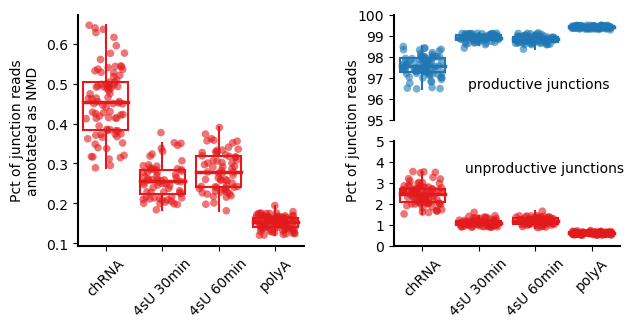

In [9]:
import matplotlib.pyplot as plt

# Create the figure and subplots
fig = plt.figure(figsize=(7, 3))

# Create the gridspec
gs = fig.add_gridspec(2, 2, wspace=0.4, hspace=0.2)

# Create the subplots using gridspec
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

sns.stripplot(data = counts, x = 'assay', y = 'Annotated_NMD', jitter=0.35, ax=ax1, alpha=0.6, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax1, zorder=4,
                    color='#e31a1c', linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='none', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax2, alpha=0.6, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax2, zorder=4,
                    color='#1f78b4', linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='none', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax3, alpha=0.6, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax3, zorder=4,
                    color='#e31a1c', linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='none', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=order)

for ax_ in [ax1, ax2, ax3]:
    ax_.spines['left'].set_linewidth(1.5)
    ax_.spines['bottom'].set_linewidth(1.5)
    ax_.spines['right'].set_visible(False)
    ax_.spines['top'].set_visible(False)
    ax_.tick_params(axis='x', rotation=45)
    ax_.set_xlabel('')
    
ax2.spines['bottom'].set_visible(False)
ax2.set_xticks([])

ax2.set_ylim([95, 100])
ax2.set_yticks([95, 96, 97, 98, 99, 100])

ax3.set_ylim([0, 5])
ax3.set_yticks([0, 1, 2, 3, 4, 5])
ax3.set_ylabel('')

ax1.set_ylabel('Pct of junction reads\nannotated as NMD')
ax2.set_ylabel('Pct of junction reads')

ax2.yaxis.set_label_coords(-0.15,-0.1)
ax2.text(0.8, 96.5, 'productive junctions')
ax3.text(0.75, 3.5, 'unproductive junctions')

plt.show()

# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.multipanel.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.multipanel.png', dpi=300, bbox_inches='tight',)

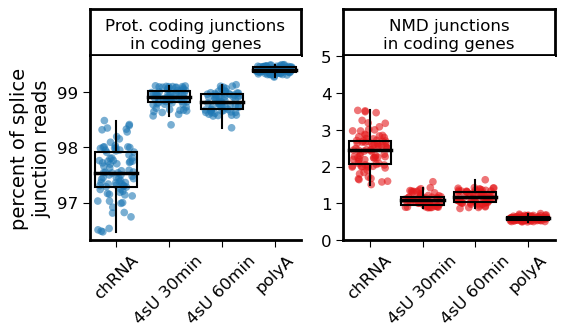

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
    
ax[1,1].set_ylim([0, 5])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')

ax[1, 1].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)


plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.png', dpi=300, bbox_inches='tight',)

In [11]:
median_unproductive_chRNA = counts.loc[counts.assay == 'chRNA'].Unproductive_juncs.median()
median_unproductive_ml30 = counts.loc[counts.assay == '4sU 30min'].Unproductive_juncs.median()
median_unproductive_ml60 = counts.loc[counts.assay == '4sU 60min'].Unproductive_juncs.median()
median_unproductive_polyA = counts.loc[counts.assay == 'polyA'].Unproductive_juncs.median()

print("NMD junctions in protein coding genes, in chRNA: {:.2f}".format(median_unproductive_chRNA) + '%')
print("NMD junctions in protein coding genes, in 4sU 30min: {:.2f}".format(median_unproductive_ml30) + '%')
print("NMD junctions in protein coding genes, in 4sU 60min: {:.2f}".format(median_unproductive_ml60) + '%')
print("NMD junctions in protein coding genes, in polyA: {:.2f}".format(median_unproductive_polyA) + '%')

NMD junctions in protein coding genes, in chRNA: 2.46%
NMD junctions in protein coding genes, in 4sU 30min: 1.09%
NMD junctions in protein coding genes, in 4sU 60min: 1.18%
NMD junctions in protein coding genes, in polyA: 0.59%


About 3.2% of junction reads in chRNA samples are unproductive. That's much more than the 0.7% observed in polyA samples. Let's see how the unproductive reads split by category.

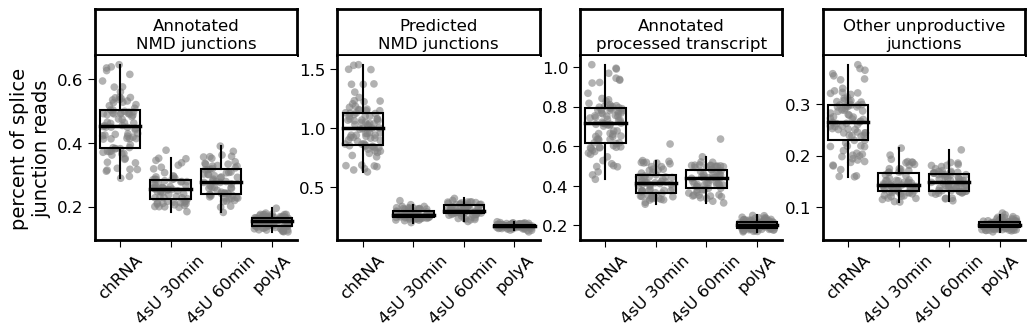

In [12]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = counts, x = 'assay', y = 'Annotated_NMD', jitter=0.35, ax=ax[1, 0], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Annotated_NMD', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Unannotated_NMD', jitter=0.35, ax=ax[1, 1], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Unannotated_NMD', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'Processed_transcripts', jitter=0.35, ax=ax[1, 2], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'Processed_transcripts', width=0.8, ax=ax[1, 2], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = counts, x = 'assay', y = 'other_unproductive', jitter=0.35, ax=ax[1, 3], alpha=0.6, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = counts, x = 'assay', y = 'other_unproductive', width=0.8, ax=ax[1, 3], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(4):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(4):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    


ax[1, 0].set_title('Annotated\nNMD junctions')
ax[1, 1].set_title('Predicted\nNMD junctions')
ax[1, 2].set_title('Annotated\nprocessed transcript')#, y=1.0, pad=12)
ax[1, 3].set_title('Other unproductive\njunctions')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
ax[1, 2].set_ylabel('')
ax[1, 3].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
ax[1,2].tick_params(length=5, labelsize=12)
ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_breakdown.png', dpi=300, bbox_inches='tight',)

The higher percentage of unproductive juntions in chRNA seems to be spread across all unproductive categories. 

# Leafcutter junctions

Let's see what happens when we use only junctions that are annotated in leafcutter clusters. This will be useful insofar as we will compare the effect of length in protein coding introns, and % NMD junctions.

In [13]:
def get_junction_counts(phenotype='chRNA.Expression.Splicing', subset_samples=[], remove_sample=None):
    
    template = '../code/SplicingAnalysis/leafcutter/clustering/autosomes/leafcutter_perind.counts.gz.{Phenotype}.gz'
    counts = pd.read_csv(template.format(Phenotype=phenotype), sep=' ')
    
    if len(subset_samples) > 0:
        counts = counts[['chrom'] + list(subset_samples)]
        counts.columns = ['cluster_id'] + list(subset_samples)
        
    if remove_sample:
        counts = counts.drop(remove_sample, axis=1)

    
    
    samples = list(counts.columns[1:])
    counts.columns = ['cluster_id'] + samples

    counts[['chrom', 'start', 'end', 'cluster']] = counts['cluster_id'].str.split(':', 3, expand=True)

    counts['strand'] = [x.split('_')[-1] for x in counts.cluster]
    counts['intron'] = counts.chrom + ':' + counts.start.astype(str)+ ':' + counts.end.astype(str) + ':' + counts.strand

    for sample in samples:
        counts[[sample, sample+'_total']] = counts[sample].str.split('/', 1, expand=True)

    counts = counts[['chrom', 'start', 'end', 'cluster', 'intron', 'strand'] + samples]

    counts['start'] = counts['start'].astype(int)
    counts['end'] = counts['end'].astype(int)
    counts[samples] = counts[samples].astype(int)
    
    return counts, samples
    

chRNA, chRNA_samples = get_junction_counts(phenotype='chRNA.Expression.Splicing', remove_sample='NA18855')

### Merging long_table to only introns with leafcutter clusters

In [14]:
chRNA['intron_coords'] = chRNA.chrom + ':' + chRNA.start.astype(str) + '-' + chRNA.end.astype(str) + ':' + chRNA.strand
long_table['intron_coords'] = long_table.chrom + ':' + long_table.start.astype(str) + '-' + long_table.end.astype(str) + ':' + long_table.strand

cluster_table = long_table.merge(chRNA[['intron_coords', 'cluster']],
                 left_on = 'intron_coords',
                 right_on = 'intron_coords')
cluster_table['intron_length'] = cluster_table.end - cluster_table.start

df_, order = longtable_to_boxplot(cluster_table)

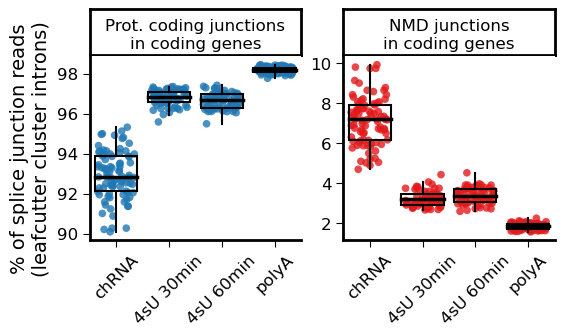

In [15]:
df_, order = longtable_to_boxplot(cluster_table)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(leafcutter cluster introns)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.png', dpi=300, bbox_inches='tight',)

Turns out that the junction reads distribution is very similar than when doing the regular mapping. This suggest that most of the differences between the 3% and the 7% figure likely are due to intron selection, rather than by the remapping itself.

In [ ]:
clu_excl = long_table.loc[~long_table.intron_coords.isin(cluster_table.intron_coords.unique())]
df_, order = longtable_to_boxplot(clu_excl)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})

sns.stripplot(data = df_, x = 'assay', y = 'Productive_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='#1f78b4', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Productive_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

sns.stripplot(data = df_, x = 'assay', y = 'Unproductive_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='#e31a1c', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
sns.boxplot(data = df_, x = 'assay', y = 'Unproductive_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)

for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Prot. coding junctions\nin coding genes')
ax[1, 1].set_title('NMD junctions\nin coding genes')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('% of splice junction reads\n(introns not in leafcutter cluster)', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.not_in_leafcutter_clusters.png', dpi=300, bbox_inches='tight',)

Non-leafcutter introns are more likely to be annotated in protein coding genes. These are probably just constitutive junctions in protein coding genes. As a result, the % of NMD junction reads is much lower in the group of junctions not in leafcutter clusters.

Thus overall I think that the 3% figure is closer to the truth.

## Effect of intron length and gene expression on % NMD

Now we will take a look at confounding factors that affect the percent of NMD junctions in chRNA. 

First we will see the effect of expression. We expect highly expressed genes to be more important and to be better regulated. As consequence, we expect highly expressed genes to have fewer NMD junctions, than lowly expressed genes.

Secondly, we will test the length of protein coding junctions in a leafcutter cluster. We hypothesize that long introns are harder to splice, and thus more prone to errors. As a result, we expect genes with long protein coding introns in the same cluster as NMD introns, to have a higher percent of NMD junction reads.

In [ ]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]

RPKM_median = RPKM[pd.Index(cluster_table.IndID.unique()).intersection(RPKM.columns)].median(axis=1)
rpkm_1, rpkm_2, rpkm_3, rpkm_4 = get_series_quantile(RPKM_median)


lt1 = long_table.loc[long_table.gene.isin(rpkm_1)]
df_rpkm1, order = longtable_to_boxplot(lt1)

lt2 = long_table.loc[long_table.gene.isin(rpkm_2)]
df_rpkm2, order = longtable_to_boxplot(lt2)

lt3 = long_table.loc[long_table.gene.isin(rpkm_3)]
df_rpkm3, order = longtable_to_boxplot(lt3)

lt4 = long_table.loc[long_table.gene.isin(rpkm_4)]
df_rpkm4, order = longtable_to_boxplot(lt4)

rpkm_df = pd.DataFrame()
unprod_juncs = list(df_rpkm1.loc[df_rpkm1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm2.loc[df_rpkm2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm3.loc[df_rpkm3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df_rpkm4.loc[df_rpkm4.assay=='chRNA'].Unproductive_juncs)

rpkm_df['unprod_juncs'] = unprod_juncs
rpkm_df['rpkm_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [ ]:
cluster_max_length = cluster_table.loc[cluster_table.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']
)].groupby('cluster').intron_length.max()

def get_series_quantile(series, gene_list=None, quant=4):
    
    if not gene_list is None:
        series = series.loc[gene_list].dropna()
    
    q = 1/quant
    
    seriesQ_list = []
    
    for i in range(quant):
        Qi = series.quantile(q*i)
        Qi2 = series.quantile(q*(i+1))
        if i == 0:
            Qi -= 1
        if i == (quant-1):
            Qi2 += 1
        seriesQi = series.loc[(series >= Qi) & (series < Qi2)].index
        
        seriesQ_list.append(seriesQi)
        
    return seriesQ_list

clu_1, clu_2, clu_3, clu_4 = get_series_quantile(cluster_max_length)

lt1 = cluster_table.loc[cluster_table.cluster.isin(clu_1)]
df1, order = longtable_to_boxplot(lt1)

lt2 = cluster_table.loc[cluster_table.cluster.isin(clu_2)]
df2, order = longtable_to_boxplot(lt2)

lt3 = cluster_table.loc[cluster_table.cluster.isin(clu_3)]
df3, order = longtable_to_boxplot(lt3)

lt4 = cluster_table.loc[cluster_table.cluster.isin(clu_4)]
df4, order = longtable_to_boxplot(lt4)

clu_df = pd.DataFrame()
unprod_juncs = list(df1.loc[df1.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df2.loc[df2.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df3.loc[df3.assay=='chRNA'].Unproductive_juncs)
unprod_juncs += list(df4.loc[df4.assay=='chRNA'].Unproductive_juncs)

clu_df['unprod_juncs'] = unprod_juncs
clu_df['length_quartile'] = ['Q1']*86 + ['Q2']*86 + ['Q3']*86 + ['Q4']*86

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=3,  gridspec_kw={'wspace': 0.3}, figsize=(10, 3))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 3), gridspec_kw={'height_ratios': [1, 4], 
                                                                       'wspace': 0.2, 'hspace': 0.01})


sns.stripplot(data=clu_df, x='length_quartile', y='unprod_juncs', jitter=0.35, ax=ax[1, 0], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data=clu_df, x='length_quartile', y='unprod_juncs', width=0.8, ax=ax[1, 0], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

sns.stripplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', jitter=0.35, ax=ax[1, 1], alpha=0.8, 
              color='gray', zorder=0, linewidth=0, edgecolor=None, s=5.5)
sns.boxplot(data = rpkm_df, x = 'rpkm_quartile', y = 'unprod_juncs', width=0.8, ax=ax[1, 1], zorder=4,
                    color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
            boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0})

# sns.stripplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = counts_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[1,x].spines['left'].set_linewidth(2)
    ax[1,x].spines['bottom'].set_linewidth(2)
    ax[1,x].spines['right'].set_visible(False)
    ax[1,x].spines['top'].set_visible(False)
    ax[1,x].tick_params(axis='x', rotation=45)
    ax[1,x].set_xlabel('')
    
for x in range(2):
    ax[0,x].spines['left'].set_linewidth(2)
    ax[0,x].spines['bottom'].set_linewidth(2)
    ax[0,x].spines['right'].set_linewidth(2)
    ax[0,x].spines['top'].set_linewidth(2)
    ax[0, x].set_xticks([])
    ax[0, x].set_yticks([])
    ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[1, 0].set_title('Leafcutter cluster length\nquartlies (pc intron)')
ax[1, 1].set_title('Gene quartiles by\nexpression (RPKM)')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1, 1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[1, 0].set_ylabel('percent of splice\njunction reads', size=14)

ax[1,0].tick_params(length=5, labelsize=12)
ax[1,1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)

plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.pdf', dpi=300, bbox_inches='tight',)
plt.savefig('../code/manuscript_plots/Fig1.confounders.LongTable.png', dpi=300, bbox_inches='tight',)

Indeed, we observe that genes in higher expression quartiles tend to have fewer NMD junction reads. Meanwhile, genes with long protein coding junctions have higher percentages of NMD junction reads.

In [ ]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

In [ ]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

NMD_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(NMD_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

pc_counts = long_table.loc[
    (long_table.Dataset=='chRNA.Expression.Splicing') &  long_table.SuperAnnotation.isin(pc_annot)
].groupby(['gene', 'IndID']).Count.sum().reset_index().pivot_table(index='gene', columns='IndID', values='Count').fillna(0)

genes_index = NMD_counts.index.intersection(pc_counts.index)

chRNA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

ml30_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/MetabolicLabelled.30min/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]
polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing.Subset_YRI/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

YRI_samples = RPKM.columns[5:]


In [ ]:
polyA_log2RPKM = polyA_RPKM[polyA_RPKM.columns[5:]].median(axis=1)
ml30_log2RPKM = ml30_RPKM[ml30_RPKM.columns[5:]].median(axis=1)
chRNA_log2RPKM = chRNA_RPKM[chRNA_RPKM.columns[5:]].median(axis=1)


polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
ml30_log2RPKM.index = [x.split('.')[0] for x in ml30_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
NMD_counts.index = [x.split('.')[0] for x in NMD_counts.index]
pc_counts.index = [x.split('.')[0] for x in pc_counts.index]


chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(polyA_genes).intersection(NMD_counts.index).intersection(pc_counts.index)


total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts

chRNA_juncs_NMD_ratio = np.log2(NMD_percent.loc[genes_index].mean(axis=1))




NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
chRNA_polyA_log2_difference = chRNA_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]
ml30_polyA_log2_difference = ml30_log2RPKM.loc[genes_index] - polyA_log2RPKM.loc[genes_index]

In [ ]:
chRNA_genes = chRNA_log2RPKM.loc[chRNA_log2RPKM > -10].index
polyA_genes = polyA_log2RPKM.loc[polyA_log2RPKM > -10].index
genes_index = chRNA_genes.intersection(genes_index).intersection(polyA_genes)

In [ ]:
total_counts = NMD_counts.loc[genes_index] + pc_counts.loc[genes_index]
NMD_percent = NMD_counts.loc[genes_index]/total_counts


In [ ]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax[0], xy=(0.45, 0.1), **kwargs)

plot_correlation(ml30_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='forestgreen', #title='chRNA',
                 xlabel='4sU RNA log2 RPKM', ax=ax[1], xy=(0.45, 0.1), **kwargs)

plot_correlation(polyA_log2RPKM.loc[genes_index], np.log2(NMD_percent.mean(axis=1)),
                 contour_color='red', #title='chRNA',
                 xlabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log2 %NMD', size=14)

ax[1].set_yticks([])
ax[2].set_yticks([])

plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_RPKM_v_NMD.png', dpi=300, bbox_inches='tight',)

In [ ]:
figdir = '/project2/yangili1/cfbuenabadn/ChromatinSplicingQTLs/code/manuscript_plots/'

kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(figsize=(3,3))

plot_correlation(chRNA_log2RPKM.loc[genes_index], polyA_log2RPKM.loc[genes_index],
                 contour_color='#1e7cff', ylabel='polyA log2 RPKM', #title='chRNA',
                 xlabel='chRNA log2 RPKM', ax=ax, xy=(0.55, 0.1), **kwargs)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=14)
ax.set_xlabel('chRNA log2 RPKM', size=14)
ax.set_ylabel('polyA log2 RPKM', size=14)

plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

In [ ]:
def plot_cumulative_quantiles(X, quantile_list, color_list, label_list = None,
                               method='median', ax=None, plot_legend = False, norm_to_Q1 = False, 
                               **kwargs):
    for i in range(len(quantile_list)):
        Qi = quantile_list[i]
        color = color_list[i]
        
        if label_list is None:
            label = 'Q' + str(i+1)
        else:
            label = label_list[i]
            
        X_to_plot = np.array(X.loc[Qi])
            
        if norm_to_Q1:
            if i == 0:
                Q1_ = X_to_plot
                continue
            else:
                X_to_plot = X_to_plot/Q1_

        plot_cumulative(X_to_plot, c=color, ax=ax, label=label)
            
        
                
    if ax:
        if plot_legend:
            if 'legend_title' in kwargs:
                ax.legend(title = kwargs['legend_title'], frameon=False, 
                          loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                ax.legend(frameon=False,
                         loc='center left', bbox_to_anchor=(1, 0.5))
        if 'xlim' in kwargs:
            ax.set_xlim(kwargs['xlim'])
        if 'ylim' in kwargs:
            ax.set_ylim(kwargs['ylim'])
        if 'xticks' in kwargs:
            ax.set_xticks(kwargs['xticks'])
        if 'xticklabels' in kwargs:
            ax.set_xticklabels(kwargs['xticklabels'])
        if 'yticks' in kwargs:
            ax.set_yticks(kwargs['yticks'])
        if 'yticklabels' in kwargs:
            ax.set_yticklabels(kwargs['yticklabels'])
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #ax.tick_params(size=4, width=2, labelsize=kwargs['fontsize'])
        if 'vertical_line_at' in kwargs:
            ax.plot([kwargs['vertical_line_at'], kwargs['vertical_line_at']], 
                    [0, 1], linestyle='--', c='gray')
        if 'xlabel' in kwargs:
            ax.set_xlabel(kwargs['xlabel'], fontsize=kwargs['fontsize'])
        if 'ylabel' in kwargs:
            ax.set_ylabel(kwargs['ylabel'], fontsize=kwargs['fontsize'])
        if 'title' in kwargs:
            ax.set_title(kwargs['title'], fontsize=kwargs['fontsize'])


In [ ]:
# We get H3K36ME3 coverage over the gene body
h3k36me3_logRPKM = pd.read_csv(
    '../code/QTLs/QTLTools/H3K36ME3/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)

h3k36me3_logRPKM = h3k36me3_logRPKM[h3k36me3_logRPKM.columns[5:]]
h3k36me3_logRPKM.index = [x.split('.')[0] for x in h3k36me3_logRPKM.index]

# Get log2 fold difference
h3k36me3_log2RPKM = h3k36me3_logRPKM.loc[genes_index]
h3k36me3_polyA_log2_difference = h3k36me3_log2RPKM.median(axis=1) - polyA_log2RPKM


# For H3K4ME3, it's a bit trickier. We get the CPM of the peaks that are close (within 2000 bp) of
# a TSS for each gene

H3K4ME3_TSS = pd.read_csv('../code/featureCounts/H3K4ME3/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K4ME3_names = [x.split('ME3/')[1].split('.1')[0] for x in H3K4ME3_TSS.columns if ('Alignments' in x)]

H3K4ME3 = pd.read_csv('../code/QTLs/QTLTools/H3K4ME3/CountsPeaksAtTSS.bed.gz',#'../../H3K4ME3.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K4ME3_names + ['overlap_len'])
                     
H3K4ME3_samples = [x for x in H3K4ME3.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K4ME3 = H3K4ME3.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K4ME3_counts = H3K4ME3.groupby('ensembl_id')[H3K4ME3_samples].sum()
h3k4me3_CPM = H3K4ME3_counts.divide(H3K4ME3_counts.sum(axis=0), axis=1)*1e6

h3k4me3_CPM = h3k4me3_CPM[H3K4ME3_samples]
h3k4me3_CPM = h3k4me3_CPM.loc[h3k4me3_CPM.median(axis=1) > 0]
h3k4me3_CPM.index = [x.split('.')[0] for x in h3k4me3_CPM.index]

h3k4me3_idx = genes_index.intersection(h3k4me3_CPM.index)
h3k4me3_log2RPKM = np.log2(h3k4me3_CPM.loc[h3k4me3_idx]) 
h3k4me3_log2RPKM = h3k4me3_log2RPKM.loc[h3k4me3_log2RPKM.median(axis=1) > -1e100]
h3k4me3_idx = h3k4me3_log2RPKM.index
h3k4me3_polyA_log2_difference = h3k4me3_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k4me3_idx]




H3K27AC_TSS = pd.read_csv('../code/featureCounts/H3K27AC/Counts.txt',
                                 sep='\t', skiprows = 1)
H3K27AC_names = [x.split('27AC/')[1].split('.1')[0] for x in H3K27AC_TSS.columns if ('Alignments' in x)]

H3K27AC = pd.read_csv('../code/QTLs/QTLTools/H3K27AC/CountsPeaksAtTSS.bed.gz',#'../../H3K27AC.TSS.PeakCounts.bed.gz', 
                      sep='\t',
                     names = ['chrom', 'start', 'end', 'transcript_id', 'ensembl_id', 'strand',
                             'gene_id', 'chrom_', 'start_', 'end_', 'peak_id', 'peak_len',
                             'strand_'] + H3K27AC_names + ['overlap_len'])
                     
H3K27AC_samples = [x for x in H3K27AC.columns if ((x[:2] == 'NA') and (x[-4:] != '.bam'))]
H3K27AC = H3K27AC.groupby(['ensembl_id', 'peak_id']).max().reset_index()
H3K27AC_counts = H3K27AC.groupby('ensembl_id')[H3K27AC_samples].sum()
h3k27ac_CPM = H3K27AC_counts.divide(H3K27AC_counts.sum(axis=0), axis=1)*1e6

h3k27ac_CPM = h3k27ac_CPM[H3K27AC_samples]

h3k27ac_CPM = h3k27ac_CPM.loc[h3k27ac_CPM.median(axis=1) > 0]
h3k27ac_CPM.index = [x.split('.')[0] for x in h3k27ac_CPM.index]

h3k27ac_idx = genes_index.intersection(h3k27ac_CPM.index)
h3k27ac_log2RPKM = np.log2(h3k27ac_CPM.loc[h3k27ac_idx]) 
h3k27ac_log2RPKM = h3k27ac_log2RPKM.loc[h3k27ac_log2RPKM.median(axis=1) > -1e100]
h3k27ac_idx = h3k27ac_log2RPKM.index
h3k27ac_polyA_log2_difference = h3k27ac_log2RPKM.median(axis=1) - polyA_log2RPKM.loc[h3k27ac_idx]



In [ ]:
# chRNA vs polyA, K4ME3 vs polyA, and K36ME3 vs polyA; 4sU vs polyA

h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)

h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

# figsize = (5.25, 5.25)
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'hspace': 0.2}, figsize=(10, 3))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)

plot_cumulative_quantiles(h3k27ac_polyA_log2_difference.loc[h3k27ac_idx], NMD_ratio_quant_all_h3k27ac, 
                    sns.color_palette("Greens", 5), xlim=[-10,10], ax=ax[0],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2 (H3K27AC/polyA)', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Oranges", 5), xlim=[-10,10], ax=ax[1],
#                           vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2 (H3K4ME3/polyA)', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                    sns.color_palette("Purples", 5), xlim=[-10,10], ax=ax[2],
#                           vertical_line_at = 0,
#                           ylabel='H3K36ME3 - polyA\ncumulative distribution',
                   xlabel = 'log2 (H3K36ME3/polyA)', legend_title = '%NMD quintiles', fontsize=14,
                         label_list = [None, None, None, None, None])

# ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

# ax[0,1].set_xlabel("")
# ax[0,0].set_xlabel("")

# ax[0,1].plot([-50], [0.5], c = 'blue', label = 'chRNA')
# ax[0,1].plot([-50], [0.5], c = sns.color_palette("Greens", 5)[4], label = '4sU RNA')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Oranges", 5)[4], label = 'H3K4ME3')
# ax[2].plot([-50], [0.5], c = sns.color_palette("Purples", 5)[4], label = 'H3K36ME3')

# ax[2].legend(title = 'logFC vs polyA', frameon=False, 
#                           loc='center left', bbox_to_anchor=(1, 0.5))

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[2].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[2].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(0.6, 0.3))

ax[0].tick_params(length=5, labelsize=12, width=1)
ax[1].tick_params(length=5, labelsize=12, width=1)
ax[2].tick_params(length=5, labelsize=12, width=1)
# ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0].set_ylabel('cumulative\ndistribution',size=14)



# plt.show()

# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.png', bbox_inches='tight', dpi=300)
# plt.savefig(figdir + 'Fig1_chRNA_polyA_expression.pdf', bbox_inches='tight', dpi=300)

plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/Fig1.Supp_Histones_LFC.png', dpi=300, bbox_inches='tight',)

In [ ]:
h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, figsize=(7, 7))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Purples", 5), xlim=[-10,10], ax=ax[0, 0],
                          xlabel = 'log2 (H3K4ME3/polyA)',
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                   ['peachpuff', 'sandybrown', 'chocolate', 'sienna', 'tab:brown'], 
                          xlim=[-10,10], ax=ax[0,1],
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[1,0], label_list = [None, None, None, None, None],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   vertical_line_at = 0, xlim=[-4, 4],
                                   fontsize=14, method='')

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['navajowhite', 'khaki', 'gold', 'orange', 'tab:orange'], 
                                   ax=ax[1,1], label_list = [None, None, None, None, None],
                                   xlabel='log2FC RPKM\n4sU RNA - polyA',
                                   vertical_line_at = 0, xlim=[-4, 4],
                                   fontsize=14, method='')

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1.1, 1.3))

ax[0,0].tick_params(length=5, labelsize=12, width=1)
ax[0,1].tick_params(length=5, labelsize=12, width=1)
ax[1,0].tick_params(length=5, labelsize=12, width=1)
ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0,0].set_ylabel('cumulative\ndistribution',size=14)

for ax_ in [ax[0,0], ax[1,0], ax[0,1], ax[1,1]]:
    ax_.spines['left'].set_linewidth(1)
    ax_.spines['bottom'].set_linewidth(1)

plt.savefig(figdir + 'Fig1.coverage_distribution.adjusted_x.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Fig1.coverage_distribution.adjusted_x.png', dpi=300, bbox_inches='tight',)

In [ ]:
h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, figsize=(7, 7))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Purples", 5), xlim=[-5,5], ax=ax[0, 0],
                          xlabel = 'log2 (H3K4ME3/polyA)',
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                   ['peachpuff', 'sandybrown', 'chocolate', 'sienna', 'tab:brown'], 
                          xlim=[-5,5], ax=ax[0,1],
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[1,0], label_list = [None, None, None, None, None],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=14, method='')

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['navajowhite', 'khaki', 'gold', 'orange', 'tab:orange'], 
                                   ax=ax[1,1], label_list = [None, None, None, None, None],
                                   xlabel='log2FC RPKM\n4sU RNA - polyA',
                                   vertical_line_at = 0, xlim=[-5, 5],
                                   fontsize=14, method='')

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1.1, 1.3))

ax[0,0].tick_params(length=5, labelsize=12, width=1)
ax[0,1].tick_params(length=5, labelsize=12, width=1)
ax[1,0].tick_params(length=5, labelsize=12, width=1)
ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0,0].set_ylabel('cumulative\ndistribution',size=14)

for ax_ in [ax[0,0], ax[1,0], ax[0,1], ax[1,1]]:
    ax_.spines['left'].set_linewidth(1)
    ax_.spines['bottom'].set_linewidth(1)

plt.savefig(figdir + 'Fig1.coverage_distribution.fixed_x.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Fig1.coverage_distribution.fixed_x.png', dpi=300, bbox_inches='tight',)

In [ ]:
h3k4me3_idx = h3k4me3_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k27ac_idx = h3k27ac_idx.intersection(chRNA_juncs_NMD_ratio.index)
h3k36me3_idx = h3k36me3_polyA_log2_difference.dropna().index.intersection(chRNA_juncs_NMD_ratio.index)

fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw={'hspace': 0.5, 'wspace': 0.3}, figsize=(7, 7))

    
NMD_ratio_quant_all_genes = get_series_quantile(chRNA_juncs_NMD_ratio, quant=5)
NMD_ratio_quant_all_h3k4me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k4me3_idx], quant=5)
NMD_ratio_quant_all_h3k36me3 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k36me3_idx], quant=5)
NMD_ratio_quant_all_h3k27ac = get_series_quantile(chRNA_juncs_NMD_ratio.loc[h3k27ac_idx], quant=5)

plot_cumulative_quantiles(h3k4me3_polyA_log2_difference.loc[h3k4me3_idx], NMD_ratio_quant_all_h3k4me3, 
                    sns.color_palette("Purples", 5), xlim=[-7.5,7.5], ax=ax[0, 0],
                          xlabel = 'log2 (H3K4ME3/polyA)',
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(h3k36me3_polyA_log2_difference.loc[h3k36me3_idx], NMD_ratio_quant_all_h3k36me3, 
                   ['peachpuff', 'sandybrown', 'chocolate', 'sienna', 'tab:brown'], 
                          xlim=[-7.5,7.5], ax=ax[0,1],
                          vertical_line_at = 0,
                           label_list = [None, None, None, None, None],
                   xlabel = 'log2FC RPKM\nH3K36ME3 - polyA', legend_title = '%NMD quintiles', fontsize=14)

plot_cumulative_quantiles(chRNA_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['deepskyblue', '#1e7cff', 'blue', 'mediumblue', 'navy'], 
                                   ax=ax[1,0], label_list = [None, None, None, None, None],
                                   ylabel='cumulative\ndistribution',
                                   xlabel='log2FC RPKM\nchRNA - polyA',
                                   vertical_line_at = 0, xlim=[-7.5, 7.5],
                                   fontsize=14, method='')

plot_cumulative_quantiles(ml30_polyA_log2_difference, NMD_ratio_quant_all_genes, 
                                   ['navajowhite', 'khaki', 'gold', 'orange', 'tab:orange'], 
                                   ax=ax[1,1], label_list = [None, None, None, None, None],
                                   xlabel='log2FC RPKM\n4sU RNA - polyA',
                                   vertical_line_at = 0, xlim=[-7.5, 7.5],
                                   fontsize=14, method='')

ax[0,1].set_yticks([])
ax[1,1].set_yticks([])

color_list = sns.color_palette("Greys", 5)
for i in range(5):
    ax[1,1].plot([-50], [0.5], c = color_list[i], label = 'Q' + str(i+1))

ax[1,1].legend(title = 'NMD quintiles', frameon=False, 
                          loc='center left', bbox_to_anchor=(1.1, 1.3))

ax[0,0].tick_params(length=5, labelsize=12, width=1)
ax[0,1].tick_params(length=5, labelsize=12, width=1)
ax[1,0].tick_params(length=5, labelsize=12, width=1)
ax[1,1].tick_params(length=5, labelsize=12, width=1)

ax[0,0].set_ylabel('cumulative\ndistribution',size=14)

for ax_ in [ax[0,0], ax[1,0], ax[0,1], ax[1,1]]:
    ax_.spines['left'].set_linewidth(1)
    ax_.spines['bottom'].set_linewidth(1)

plt.savefig(figdir + 'Fig1.coverage_distribution.fixed_x_large.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Fig1.coverage_distribution.fixed_x_large.png', dpi=300, bbox_inches='tight',)

In [ ]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)
polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
chRNA_log2RPKM.index = [x.split('.')[0] for x in chRNA_log2RPKM.index]
chRNA_juncs_NMD_ratio.index = [x.split('.')[0] for x in chRNA_juncs_NMD_ratio.index]

ensembl_idx = chRNA_juncs_NMD_ratio.index.intersection(scores.index).intersection(chRNA_log2RPKM.index)
df_scores = scores.loc[ensembl_idx]
df_scores['NMD'] = np.array(chRNA_juncs_NMD_ratio.loc[ensembl_idx])
df_scores['RPKM'] = np.array(chRNA_log2RPKM.loc[ensembl_idx])
df_scores['logFC'] = np.array(chRNA_log2RPKM.loc[ensembl_idx] - polyA_log2RPKM.loc[ensembl_idx])

genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(ensembl_idx)
df_scores_sr = df_scores.loc[srsf_ensembl]
df_scores_sr['gene'] = np.array(genes.loc[srsf_ensembl].genes)

In [ ]:
def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)

In [ ]:
df_scores_sr
kwargs = {'facecolor':'none', 'edgecolor':'gray', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.5}, figsize=(13, 3))

ax[0].scatter(df_scores.RPKM, df_scores.NMD, **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[0].annotate(row.gene, (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
annotate_pval(df_scores.RPKM, df_scores.NMD, ax[0], xy = (0.05, 0.1))
    
ax[1].scatter(np.log2(df_scores.post_mean),df_scores.NMD, **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[1].annotate(row.gene, (np.log2(row.post_mean), row.NMD), c='red', size=10)
    
annotate_pval(np.log2(df_scores.post_mean), df_scores.NMD, ax[1], xy = (0.05, 0.1))

kwargs_ = {'facecolor':'none', 'edgecolor':'gray', 'alpha':0.1}

ax[2].scatter(df_scores.RPKM, np.log2(df_scores.post_mean), **kwargs_)
for idx, row in df_scores_sr.iterrows():
    ax[2].annotate(row.gene, (row.RPKM, np.log2(row.post_mean)), c='red', size=10)

annotate_pval(df_scores.RPKM, np.log2(df_scores.post_mean), ax[2], xy = (0.05, 0.1), col='black')


for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log %NMD', size=14)

ax[1].set_ylabel('log %NMD', size=14)
ax[1].set_xlabel('log $s_{het}$', size=16)


ax[2].set_xlabel('chRNA log2 RPKM', size=14)
ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])


plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [13]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]
df_scores['gene_length'] = np.array(np.log2(gene_len.loc[df_scores.index]))

NameError: name 'RPKM' is not defined

In [ ]:
def get_gene_quartiles(array, genes):
    
    feature1, feature2, feature3, feature4 = get_series_quantile(array.loc[genes], quant=4)

    feature_rank = []
    for gen in genes:
        if gen in feature1:
            feature_rank.append('Q1')
        elif gen in feature2:
            feature_rank.append('Q2')
        elif gen in feature3:
            feature_rank.append('Q3')
        elif gen in feature4:
            feature_rank.append('Q4')
    return feature_rank

rpkm1, rpkm2, rpkm3, rpkm4 = get_series_quantile(chRNA_log2RPKM.loc[ensembl_idx], quant=4)
NMD1, NMD2, NMD3, NMD4 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[ensembl_idx], quant=4)



rpkm_rank = []
for ens in ensembl_idx:
    if ens in rpkm1:
        rpkm_rank.append('Q1')
    elif ens in rpkm2:
        rpkm_rank.append('Q2')
    elif ens in rpkm3:
        rpkm_rank.append('Q3')
    elif ens in rpkm4:
        rpkm_rank.append('Q4')
    

NMD_rank = []
for gen in ensembl_idx:
    if gen in NMD1:
        NMD_rank.append('Q1')
    elif gen in NMD2:
        NMD_rank.append('Q2')
    elif gen in NMD3:
        NMD_rank.append('Q3')
    elif gen in NMD4:
        NMD_rank.append('Q4')
    
df_scores['rpkm_quartiles'] = rpkm_rank
df_scores['NMD_quartiles'] = NMD_rank


In [ ]:
df_scores['log_s_het'] = np.log2(df_scores.post_mean)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df_scores, x = 'rpkm_quartiles', y = 'log_s_het', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df_scores, x = 'NMD_quartiles', y = 'log_s_het', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)


ax[0].set_xlabel('RPKM quartiles')
ax[1].set_xlabel('NMD quartiles')
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[0].set_ylabel('log $s_{het}$', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles.s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles.s_het.png', dpi=300, bbox_inches='tight',)


In [ ]:
pLI = pd.read_csv('../../gnomad.v2.1.1.lof_metrics.by_gene.txt', sep='\t')
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]
pLI_by_gene = pLI.groupby('gene')[['exac_pLI', 'exac_obs_lof', 'exac_exp_lof', 'exac_oe_lof']].max().dropna()#.reset_index()

genes_score = df_scores.index

pLI_genes = pd.Index(pLI_by_gene.loc[pLI_by_gene.index.intersection(pd.Index(genes.loc[genes_score].genes))].index)
ensembl_ = genes.loc[genes.genes.isin(pLI_genes)].index.intersection(genes_score)
genes_ = pd.Index(genes.loc[ensembl_].genes)


df = pd.DataFrame()
df['ensembl'] = ensembl_
df['genes'] = genes_

# df['pLI'] = np.array(pLI_by_gene.loc[genes_].exac_pLI)

df['pLI'] = np.array(pLI_by_gene.loc[genes_].exac_pLI)
df['logit_pLI'] = np.array(np.log2(pLI_by_gene.loc[genes_].exac_pLI/((1-pLI_by_gene.loc[genes_].exac_pLI)+1e-7)))

df['lof'] = np.array(np.log2(pLI_by_gene.loc[genes_].exac_obs_lof))
df['NMD'] = np.array(chRNA_juncs_NMD_ratio.loc[ensembl_])
df['rpkm'] = np.array(chRNA_log2RPKM.loc[ensembl_])

def get_gene_quartiles(array, genes):
    
    feature1, feature2, feature3, feature4 = get_series_quantile(array.loc[genes], quant=4)

    feature_rank = []
    for gen in genes:
        if gen in feature1:
            feature_rank.append('Q1')
        elif gen in feature2:
            feature_rank.append('Q2')
        elif gen in feature3:
            feature_rank.append('Q3')
        elif gen in feature4:
            feature_rank.append('Q4')
    return feature_rank

rpkm1, rpkm2, rpkm3, rpkm4 = get_series_quantile(chRNA_log2RPKM.loc[ensembl_], quant=4)
pLI1, pLI2, pLI3, pLI4 = get_series_quantile(pLI_by_gene.loc[genes_].exac_pLI, quant=4)
NMD1, NMD2, NMD3, NMD4 = get_series_quantile(chRNA_juncs_NMD_ratio.loc[ensembl_], quant=4)

rpkm_rank = []
for ens in ensembl_:
    if ens in rpkm1:
        rpkm_rank.append('Q1')
    elif ens in rpkm2:
        rpkm_rank.append('Q2')
    elif ens in rpkm3:
        rpkm_rank.append('Q3')
    elif ens in rpkm4:
        rpkm_rank.append('Q4')
    
pLI_rank = []
for gen in genes_:
    if gen in pLI1:
        pLI_rank.append('Q1')
    elif gen in pLI2:
        pLI_rank.append('Q2')
    elif gen in pLI3:
        pLI_rank.append('Q3')
    elif gen in pLI4:
        pLI_rank.append('Q4')
        
NMD_rank = []
for gen in ensembl_:
    if gen in NMD1:
        NMD_rank.append('Q1')
    elif gen in NMD2:
        NMD_rank.append('Q2')
    elif gen in NMD3:
        NMD_rank.append('Q3')
    elif gen in NMD4:
        NMD_rank.append('Q4')
    
df['rpkm_quartiles'] = rpkm_rank
df['pLI_quartiles'] = pLI_rank
df['NMD_quartiles'] = NMD_rank

df = df.set_index('ensembl')
# df['lof_quartiles'] = get_gene_quartiles(df.lof, df.index)


In [ ]:

# sns.boxplot(data = df, x='rpkm_quartiles', y='pLI', order=['Q1', 'Q2', 'Q3', 'Q4'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df, x = 'rpkm_quartiles', y = 'pLI', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df, x = 'NMD_quartiles', y = 'pLI', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)

ax[0].set_xlabel('RPKM quartiles')
ax[1].set_xlabel('NMD quartiles')

ax[1].set_ylabel('')
ax[0].set_ylabel('pLI score', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles_v_pLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles_v_pLI.png', dpi=300, bbox_inches='tight',)

In [ ]:

# sns.boxplot(data = df, x='rpkm_quartiles', y='pLI', order=['Q1', 'Q2', 'Q3', 'Q4'])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.01})


sns.boxplot(data = df, x = 'rpkm_quartiles', y = 'logit_pLI', width=0.8, ax=ax[0], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#1f78b4'),
            whiskerprops=dict(color='#1f78b4'),
            medianprops=dict(color='#1f78b4', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

sns.boxplot(data = df, x = 'NMD_quartiles', y = 'logit_pLI', width=0.8, ax=ax[1], zorder=4,
                    linewidth=1.5, showfliers=False, 
            boxprops=dict(facecolor='white', edgecolor='#e31a1c'),
            whiskerprops=dict(color='#e31a1c'),
            medianprops=dict(color='#e31a1c', linewidth=2.5),
            capprops={'linewidth':0, }, order=['Q1', 'Q2', 'Q3', 'Q4'])

# sns.stripplot(data = df_, x = 'assay', y = 'Noncoding_juncs', jitter=0.35, ax=ax[1, 2], alpha=0.8, 
#               color='#6a3d9a', zorder=0, linewidth=0, edgecolor=None, s=5.5, order=order)
# sns.boxplot(data = df_, x = 'assay', y = 'Noncoding_juncs', width=0.8, ax=ax[1, 2], zorder=4,
#                     color='black', linewidth=1.5, medianprops={'linewidth': 2.5},
#             boxprops={'facecolor': 'none'}, showfliers=False, capprops={'linewidth':0}, order=order)


for x in range(2):
    ax[x].spines['left'].set_linewidth(2)
    ax[x].spines['bottom'].set_linewidth(2)
    ax[x].spines['right'].set_visible(False)
    ax[x].spines['top'].set_visible(False)
    ax[x].tick_params(axis='x', rotation=45)
    ax[x].set_xlabel('')
    
ax[1].spines['left'].set_visible(False)
# for x in range(2):
#     ax[0,x].spines['left'].set_linewidth(2)
#     ax[0,x].spines['bottom'].set_linewidth(2)
#     ax[0,x].spines['right'].set_linewidth(2)
#     ax[0,x].spines['top'].set_linewidth(2)
#     ax[0, x].set_xticks([])
#     ax[0, x].set_yticks([])
#     ax[0, x].patch.set_facecolor('none')
#     ax[0,x].tick_params(axis='x', rotation=45)
    
# ax[1,1].set_ylim([0, 4.05])

ax[0].set_xlabel('RPKM quartiles', size=14)
ax[1].set_xlabel('NMD quartiles', size=14)
# ax[1, 2].set_title('Junctions in\nnon-coding genes')#, y=1.0, pad=12)

ax[1].set_ylabel('')
# ax[1, 2].set_ylabel('')
ax[0].set_ylabel('logit pLI score', size=14)

ax[1].set_yticks([])

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)
# ax[1,2].tick_params(length=5, labelsize=12)
# ax[1,3].tick_params(length=5, labelsize=12)



plt.savefig(figdir + 'supplementary_figures/quartiles_v_logitpLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/quartiles_v_logitpLI.png', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.pdf', dpi=300, bbox_inches='tight',)
# plt.savefig('../code/manuscript_plots/Fig1.NMD_percent.leafcutter_clusters.just_box.png', dpi=300, bbox_inches='tight',)

In [ ]:
df_srsf = df.loc[df.genes.isin(['SRSF'+str(x) for x in range(13)])]

In [ ]:
kwargs = {'facecolor':'none', 'edgecolor':'black', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.5}, figsize=(8, 3))

ax[0].scatter(df.rpkm, df.NMD, **kwargs)
for idx, row in df_srsf.iterrows():
    ax[0].annotate(row.genes, (row.rpkm-1, row.NMD-0.2), c='red', size=10)
    
ax[1].scatter(df.NMD, df.pLI, **kwargs)
for idx, row in df_srsf.iterrows():
    ax[1].annotate(row.genes, (row.NMD, row.pLI), c='red', size=10)


# plot_correlation(df.exon_counts, df.logit_pLI,
#                  contour_color='#1e7cff', ylabel='logit pLI score', #title='chRNA',
#                  xlabel='log exon number', ax=ax[0], xy=(0.45, 0.1), **kwargs)

# plot_correlation(df.gene_length, df.logit_pLI,
#                  contour_color='forestgreen', #title='chRNA',
#                  xlabel='log gene length', ax=ax[1], xy=(0.45, 0.1), **kwargs)

# plot_correlation(df.intron_counts, df.logit_pLI,
#                  contour_color='red', #title='chRNA',
#                  xlabel='polyA log2 RPKM', ax=ax[2], xy=(0.45, 0.1), **kwargs)

for i in range(2):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log2 %NMD', size=14)

ax[1].set_xlabel('log %NMD', size=14)
ax[1].set_ylabel('pLI score', size=14)

# ax[1].set_yticks([])
# ax[2].set_yticks([])

plt.savefig(figdir + 'supplementary_figures/features_v_pLI.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/features_v_pLI.png', dpi=300, bbox_inches='tight',)

In [ ]:
import gtfparse
gtf_df = gtfparse.read_gtf('../code/ReferenceGenome/Annotations/gencode.v34.chromasomal.basic.annotation.gtf')

gtf_df = gtf_df.loc[gtf_df.feature=='exon']
gtf_df['exon_count'] = [1]*gtf_df.shape[0]

transcripts = gtf_df.groupby(['gene_id', 'gene_name', 'transcript_id']).exon_count.sum().reset_index()

genes_exons = transcripts.groupby(['gene_id', 'gene_name']).exon_count.max().reset_index().set_index('gene_id')
genes_exons.index = [x.split('.')[0] for x in genes_exons.index]

In [ ]:
m2h = pd.read_csv('../../m2h.tab.gz', sep='\t')
annotation = pd.read_csv('/project2/yangili1/cfbuenabadn/1-s2.0-S1097276517300370-mmc3.tab', sep='\t')
tf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Chromatin/TF', 'Overlap'])].EnsemblGeneID
sf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Splicing factor/RBP', 'Overlap'])].EnsemblGeneID
tf_sf_mouse_ensembl = annotation.loc[annotation.Group.isin(['Overlap'])].EnsemblGeneID
human_sf = list(m2h.loc[m2h.ensembl_gene_id.isin(sf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)
human_tf = list(m2h.loc[m2h.ensembl_gene_id.isin(tf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)
human_tf_sf = list(m2h.loc[m2h.ensembl_gene_id.isin(tf_sf_mouse_ensembl)].hsapiens_homolog_associated_gene_name)

sf_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(human_sf)].hsapiens_homolog_ensembl_gene)

srsf_ensembl = pd.Index(m2h.loc[m2h.hsapiens_homolog_associated_gene_name.isin(srsf)].hsapiens_homolog_ensembl_gene)


In [ ]:
df_scores_sr
kwargs = {'facecolor':'none', 'edgecolor':'gray', 'alpha':0.1}

fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw={'wspace': 0.5}, figsize=(13, 3))

ax[0].scatter(df_scores.RPKM, df_scores.NMD, **kwargs)

ax[0].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].RPKM, 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].NMD, facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')

for idx, row in df_scores_sr.iterrows():
    ax[0].annotate(row.gene, (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
annotate_pval(df_scores.RPKM, df_scores.NMD, ax[0], xy = (0.05, 0.2))
    
ax[1].scatter(np.log2(df_scores.post_mean),df_scores.NMD, **kwargs)
for idx, row in df_scores_sr.iterrows():
    ax[1].annotate(row.gene, (np.log2(row.post_mean), row.NMD), c='red', size=10)
    
ax[1].scatter(np.log2(df_scores.loc[sf_ensembl.intersection(dfreg.index)].post_mean), 
              dfreg.loc[sf_ensembl.intersection(dfreg.index)].NMD, facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')

for idx, row in df_scores_sr.iterrows():
    ax[1].annotate(np.log2(row.post_mean), (row.RPKM-1, row.NMD-0.2), c='red', size=10)
    
annotate_pval(np.log2(df_scores.post_mean), df_scores.NMD, ax[1], xy = (0.05, 0.2))
    

kwargs_ = {'facecolor':'none', 'edgecolor':'gray', 'alpha':0.1}

ax[2].scatter(df_scores.RPKM, np.log2(df_scores.post_mean), **kwargs_)

ax[2].scatter(dfreg.loc[sf_ensembl.intersection(dfreg.index)].RPKM, 
              np.log2(df_scores.loc[sf_ensembl.intersection(dfreg.index)].post_mean), facecolor='none', edgecolor ='yellow', 
              alpha=0.8, label='splicing factor')


for idx, row in df_scores_sr.iterrows():
    ax[2].annotate(row.gene, (row.RPKM, np.log2(row.post_mean)), c='red', size=10)

annotate_pval(df_scores.RPKM, np.log2(df_scores.post_mean), ax[2], xy = (0.05, 0.2), col='black')


for i in range(3):
    ax[i].spines['left'].set_linewidth(2)
    ax[i].spines['bottom'].set_linewidth(2)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(length=5, labelsize=14)
    
ax[0].set_xlabel('chRNA log2 RPKM', size=14)
ax[0].set_ylabel('log %NMD', size=14)

ax[1].set_ylabel('log %NMD', size=14)
ax[1].set_xlabel('log $s_{het}$', size=16)


ax[2].set_xlabel('chRNA log2 RPKM', size=14)
ax[2].set_ylabel('log $s_{het}$', size=16)

# ax[1].set_yticks([])
# ax[2].set_yticks([])
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)


plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'supplementary_figures/SRSF_NMD_v_RPKM_v_s_het.png', dpi=300, bbox_inches='tight',)

In [ ]:
def filter_by_quartile(df, feature, quartile='50%', top=True):
    q = df.describe().loc[quartile, feature]
    if top:
        df_q = df.loc[df[feature]>q]
    else:
        df_q = df.loc[df[feature]<=q]
    
    return df_q

dfreg = pd.DataFrame()
dfreg['RPKM'] = df_scores.RPKM
dfreg['gene_length'] = np.array(df_scores.gene_length)
dfreg['log_s_het'] = np.array(df_scores.log_s_het)
dfreg['NMD'] = np.array(df_scores.NMD)

# dfreg = dfreg.loc[dfreg.RPKM > np.log2(5)]

dfreg['zRPKM'] = zscore(df_scores.loc[dfreg.index].RPKM)
dfreg['zgene_length'] = zscore(df_scores.loc[dfreg.index].gene_length)
dfreg['zlog_s_het'] = zscore(df_scores.loc[dfreg.index].log_s_het)
dfreg['zNMD'] = zscore(df_scores.loc[dfreg.index].NMD)

dfreg = dfreg.merge(genes_exons, right_index=True, left_index=True)

top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='75%')
top_s = filter_by_quartile(dfreg, 'log_s_het', quartile='75%')
top_top_ = top_expressed.index.intersection(top_s.index)
top_nmd_ = filter_by_quartile(dfreg.loc[top_top_], 'NMD', quartile='75%')

gene_list = list(top_nmd_.gene_name)

In [ ]:
import gseapy as gp
from gseapy import barplot, dotplot

In [ ]:
enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c2.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes NMD Q4\nMSigDB C2 Pathways',cmap='viridis', size=20, figsize=(3,5))

In [ ]:
barplot(enr2.res2d,title='Important genes NMD Q4\nMSigDB C2 Pathways', figsize=(4, 5), color='darkred')


In [ ]:
enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

In [ ]:
dotplot(enr2.res2d, title='Important genes NMD Q4\nMSigDB C5 Ontology',cmap='viridis', size=30, figsize=(3,5))

In [ ]:
barplot(enr2.res2d,title='Important genes NMD Q4\nMSigDB C5 Ontology', figsize=(4, 5), color='darkred')


In [ ]:
top_expressed = filter_by_quartile(dfreg, 'RPKM', quartile='75%')
top_s = filter_by_quartile(dfreg, 'log_s_het', quartile='75%')
top_top_ = top_expressed.index.intersection(top_s.index)
top_nmd_ = filter_by_quartile(dfreg.loc[top_top_], 'NMD', quartile='25%', top=False)

gene_list = list(top_nmd_.gene_name)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.all.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes NMD Q1\nMSigDB C5 Ontology', cmap='viridis', size=10, figsize=(3,5))
barplot(enr2.res2d,title='title', figsize=(4, 5), color='darkred')


In [ ]:
polyA_log2RPKM.index = [x.split('.')[0] for x in polyA_log2RPKM.index]
genes_idx= polyA_log2RPKM.index.intersection(chRNA_log2RPKM.index).intersection(chRNA_juncs_NMD_ratio.index).intersection(
ml30_log2RPKM.index).intersection(h3k36me3_log2RPKM.index).intersection(gene_len.index).intersection(
    h3k4me3_log2RPKM.index).intersection(h3k27ac_log2RPKM.index).intersection(df_scores.index)

In [ ]:
df = pd.DataFrame()
df['polyA'] = zscore(polyA_log2RPKM.loc[genes_idx])
df['chRNA'] = zscore(chRNA_log2RPKM.loc[genes_idx])
df['NMD'] = zscore(chRNA_juncs_NMD_ratio.loc[genes_idx])
df['4sU'] = zscore(ml30_log2RPKM.loc[genes_idx])
df['H3K27AC'] = zscore(h3k27ac_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K4ME3'] = zscore(h3k4me3_log2RPKM.loc[genes_idx].median(axis=1))
df['H3K36ME3'] = zscore(h3k36me3_log2RPKM.loc[genes_idx].median(axis=1))
df['gene_length'] = zscore(np.log2(gene_len.loc[genes_idx]))
df['log2_s_score'] = zscore(np.log2(df_scores.post_mean))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length', 'log2_s_score'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))


In [ ]:
df_resid = pd.DataFrame(np.zeros([4, 4]))
df_resid.columns = ['histones', 'chRNA', '4sU', 'polyA']
df_resid.index = ['histones', 'chRNA', '4sU', 'polyA']

In [ ]:
for assay in ['chRNA', '4sU', 'polyA']:
    model, r2 = run_regression(df, ['H3K27AC', 'H3K4ME3','H3K36ME3', 'gene_length', 'log2_s_score'], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, 'histones'] = var['NMD']

In [ ]:
for assay in ['4sU', 'polyA']:
    model, r2 = run_regression(df, ['chRNA', 'gene_length', 'log2_s_score'], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, 'chRNA'] = var['NMD']

In [ ]:
for assay in ['polyA']:
    model, r2 = run_regression(df, ['4sU', 'gene_length', 'log2_s_score'], assay)
    df['residuals'] = zscore(model.resid)

    model2, r22 = run_regression(df, ['NMD'], 'residuals')
    var = get_var_explained(model2.params, r22)
    print(assay)
    print(var)

    df_resid.loc[assay, '4sU'] = var['NMD']

In [ ]:
df_resid = df_resid * 100

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
g = sns.heatmap(df_resid, mask=np.triu(np.ones_like(df_resid)), cmap='viridis', cbar=False, ax=ax)
g.set_yticks([1.5, 2.5, 3.5], ['chRNA', '4sU 30min', 'polyA'])
g.set_xticks([0.5, 1.5, 2.5], ['histone marks', 'chRNA', '4sU 30min'])
g.text(0.5, 1.5, "{:.1f}%".format(df_resid.loc['chRNA', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 2.5, "{:.1f}%".format(df_resid.loc['4sU', 'histones']), ha="center", va="center", color="w")
g.text(0.5, 3.5, "{:.1f}%".format(df_resid.loc['polyA', 'histones']), ha="center", va="center", color="black")
g.text(1.5, 2.5, "{:.1f}%".format(df_resid.loc['4sU', 'chRNA']), ha="center", va="center", color="w")
g.text(1.5, 3.5, "{:.1f}%".format(df_resid.loc['polyA', 'chRNA']), ha="center", va="center", color="black")
g.text(2.5, 3.5, "{:.1f}%".format(df_resid.loc['polyA', '4sU']), ha="center", va="center", color="w")
ax.text(0, 4.6, 'Percent residual variance explained by NMD')
# g.set_title_coords(-0.15,-0.1)


In [ ]:
g.hist

In [ ]:
np.triu(np.ones_like(df_resid))

In [ ]:
model, r2 = run_regression(df, ['H3K27AC', 'H3K4ME3','H3K36ME3', 'gene_length', 'log2_s_score'], 'polyA')
df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD'], 'residuals')
var = get_var_explained(model2.params, r22)
print(var)

df_resid.loc['polyA', 'histones'] = var['NMD']

In [ ]:
model, r2 = run_regression(df, ['chRNA', 'H3K27AC', 'H3K4ME3','H3K36ME3', 'NMD', 'gene_length', 'log2_s_score'], 
                           'polyA', robust = False)

print(get_var_explained(model.params, r2))

In [ ]:
model, r2 = run_regression(df, ['H3K27AC', 'H3K4ME3','H3K36ME3', 'gene_length', 'log2_s_score'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
model, r2 = run_regression(df, ['H3K27AC', 'H3K4ME3','H3K36ME3', 'gene_length', 'log2_s_score'], 'chRNA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
model, r2 = run_regression(df, ['chRNA', 'gene_length', 'log2_s_score'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
model, r2 = run_regression(df, ['chRNA', 'gene_length', 'log2_s_score'], 'ml30')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['NMD'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
model, r2 = run_regression(df, ['chRNA', 'NMD', 'log2_s_score'], 'ml30')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
model, r2 = run_regression(df, ['ml30', 'NMD', 'log2_s_score'], 'polyA')

df['residuals'] = zscore(model.resid)

model2, r22 = run_regression(df, ['gene_length'], 'residuals')

var = get_var_explained(model2.params, r22)
print(var)

In [ ]:
0.04361228640928361 + 0.024138957481997347

In [ ]:
chRNA_juncs_NMD_ratio

In [ ]:
gene_len

In [ ]:
plt.hist(np.log2(df_scores.post_mean))

In [8]:
def filter_by_quartile(df, feature, quartile='50%', top=True):
    q = df.describe().loc[quartile, feature]
    if top:
        df_q = df.loc[df[feature]>q]
    else:
        df_q = df.loc[df[feature]<=q]
    
    return df_q

In [10]:
NMD_annot = ['UnannotatedJunc_UnproductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene']
pc_annot = ['UnannotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_ProductiveCodingGene']

long_unprod = long_table.loc[long_table.SuperAnnotation.isin(NMD_annot)]

long_unprod = long_unprod.groupby(
    ['chrom', 'start', 'end', 'strand', 'gene']
                ).Count.sum().reset_index()[['chrom', 'start', 'end', 'gene', 'Count', 'strand']]

long_unprod.gene = [x.split('.')[0] for x in long_unprod.gene]
long_unprod['intron_counts'] = [1]*len(long_unprod)


In [14]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]

In [15]:
long_unprod = long_unprod.merge(pd.DataFrame(gene_len, columns=['gene_length']), left_on='gene', right_index=True)

In [16]:
summary_unprod = long_unprod.groupby('gene')[['Count', 'intron_counts']].sum().merge(
    pd.DataFrame(gene_len, columns=['gene_length']), left_index=True, right_index=True)

In [17]:
top_counts = filter_by_quartile(summary_unprod, 'Count', quartile='75%')
top_introns = filter_by_quartile(summary_unprod, 'intron_counts', quartile='75%')
short_genes = filter_by_quartile(summary_unprod, 'gene_length', quartile='25%', top=False)

In [18]:
super_nmd = top_counts.index.intersection(top_introns.index).intersection(short_genes.index)

In [20]:
summary_unprod.loc[super_nmd].sort_values('gene_length').head(30)

,Count,intron_counts,gene_length
ENSG00000054148,4825,14,2304
ENSG00000239779,7165,11,2492
ENSG00000100445,10013,11,3140
ENSG00000114388,7819,12,3497
ENSG00000169241,7203,12,3514
ENSG00000162004,9471,15,4373
ENSG00000066322,7094,11,4677
ENSG00000125459,11669,19,4747
ENSG00000100258,9399,13,4754
ENSG00000239382,7583,11,5120


In [ ]:
long_table.gene = [x.split('.')[0] for x in long_table.gene]

In [ ]:
super_nmd_bed = long_table.loc[
    long_table.gene.isin(super_nmd) & (long_table.Dataset == 'Expression.Splicing') & (long_table.RepNumber=='1.junc')
][['chrom', 'start', 'end', 'gene', 'Count', 'strand', 'SuperAnnotation']]

In [ ]:
super_nmd_annot_prod = super_nmd_bed.loc[super_nmd_bed.SuperAnnotation == 'AnnotatedJunc_ProductiveCodingGene']
super_nmd_unann_prod = super_nmd_bed.loc[super_nmd_bed.SuperAnnotation == 'UnannotatedJunc_ProductiveCodingGene']
super_nmd_annot_unpr = super_nmd_bed.loc[super_nmd_bed.SuperAnnotation == 'AnnotatedJunc_UnproductiveCodingGene']
super_nmd_unann_unpr = super_nmd_bed.loc[super_nmd_bed.SuperAnnotation == 'UnannotatedJunc_UnproductiveCodingGene']

In [ ]:
super_nmd_annot_prod.groupby(['chrom', 'start', 'end', 'gene', 'strand']).Count.sum().reset_index()[
    ['chrom', 'start', 'end', 'gene', 'Count', 'strand']].to_csv(
    '../../Annotated.Productive.junctions.bed.gz', sep='\t', index=False, header=False)

super_nmd_unann_prod.groupby(['chrom', 'start', 'end', 'gene', 'strand']).Count.sum().reset_index()[
    ['chrom', 'start', 'end', 'gene', 'Count', 'strand']].to_csv(
    '../../Unannotated.Productive.junctions.bed.gz', sep='\t', index=False, header=False)

super_nmd_annot_unpr.groupby(['chrom', 'start', 'end', 'gene', 'strand']).Count.sum().reset_index()[
    ['chrom', 'start', 'end', 'gene', 'Count', 'strand']].to_csv(
    '../../Annotated.Unproductive.junctions.bed.gz', sep='\t', index=False, header=False)

super_nmd_unann_unpr.groupby(['chrom', 'start', 'end', 'gene', 'strand']).Count.sum().reset_index()[
    ['chrom', 'start', 'end', 'gene', 'Count', 'strand']].to_csv(
    '../../Unannotated.Unproductive.junctions.bed.gz', sep='\t', index=False, header=False)

In [ ]:
super_nmd_annot_prod.groupby(['chrom', 'start', 'end', 'gene', 'strand']).Count.sum().reset_index()

In [ ]:
long_table.loc[long_table.gene=='ENSG00000237094']

In [ ]:
len(long_table.gene.unique())

In [ ]:
long_table_genes = long_table.loc[long_table.SuperAnnotation.isin(
    ['AnnotatedJunc_ProductiveCodingGene', 'AnnotatedJunc_UnproductiveCodingGene',
     'UnannotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
)]